In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
import pybert as pb

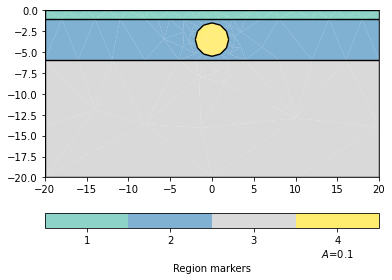

In [2]:
world = mt.createWorld(start=[-20, 0], end=[20, -20], layers=[-1, -6], worldMarker=1)
# Create some heterogeneous circle and merge with world
block = mt.createCircle(pos=[0, -3.5], radius=2, marker=4, boundaryMarker=10, area=0.1)
geom = mt.mergePLC([world, block])
pg.show(geom);

In [3]:
# place electrodes in the mesh and refine them
xEl = np.linspace(-10, 10, 21)
[geom.createNode((x, 0, 0), -99) for x in xEl]
[geom.createNode((x, -0.1, 0)) for x in xEl]
mesh = mt.createMesh(geom)
print(mesh)

Mesh: Nodes: 672 Cells: 1179 Boundaries: 1850


In [4]:
data = ert.createData(elecs=xEl, schemeName='dd')
data["k"] = ert.geometricFactors(data)
print(data)

Data: Electrodes: 21 data: 171


In [5]:
rhoMap = np.array([0, 100, 300, 30, 100], dtype=float)
rhoVec = rhoMap[mesh.cellMarkers()]
print(np.unique(rhoVec))

[ 30. 100. 300.]


20/12/22 - 10:49:58 - pyGIMLi - INFO - Found 1 regions.
20/12/22 - 10:49:58 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/12/22 - 10:49:58 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


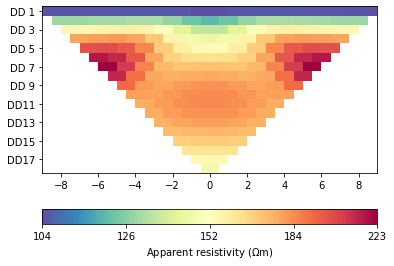

In [6]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
data["rhoa"] = fopDC.response(rhoVec)
pg.show(data, "rhoa");

In [7]:
fopDC.createJacobian(rhoVec)

In [8]:
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)

1

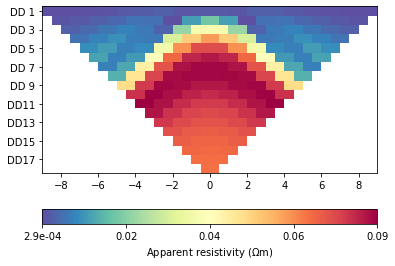

In [9]:
mMap = np.array([0, 0, 0, 0.1, 0.3])
mVec = mMap[mesh.cellMarkers()]
data["ma"] = fopIP.response(mVec)
pg.show(data, "ma", logScale=False);
data.save("simpleTDIP.dat", "a b m n rhoa k ma")

20/12/22 - 10:50:00 - pyGIMLi - INFO - Found 2 regions.
20/12/22 - 10:50:00 - pyGIMLi - INFO - Region with smallest marker (1) set to background
20/12/22 - 10:50:00 - pyGIMLi - INFO - Creating forward mesh from region infos.
20/12/22 - 10:50:01 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.
20/12/22 - 10:50:01 - pyGIMLi - INFO - Use median(data values)=174.37618966372395
20/12/22 - 10:50:01 - pyGIMLi - INFO - Created startmodel from forward operator: 793 [174.37618966372395,...,174.37618966372395]


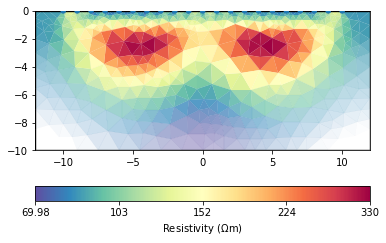

In [10]:
data["err"] = ert.estimateError(data, 0.03)
mgr = ert.Manager(data)
mgr.invert(paraDX=0.25, paraDepth=10, quality=34.4, paraMaxCellSize=1)
mgr.showResult();

20/12/22 - 10:50:03 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.modelling.DCIPMModelling object at 0x000001D5F2B97E50>
Data transformation: <pygimli.core._pygimli_.RTrans object at 0x000001D5F2C00940>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x000001D5F2B97680>
min/max (data): 2.9e-04/0.09
min/max (error): 4.16%/342%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 856.26 (dPhi = 72.3%) lam: 10
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 51.04 (dPhi = 93.88%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 16.17 (dPhi = 64.28%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 2.81 (dPhi = 68.36%) lam: 10.0
-----------------------------------------------------

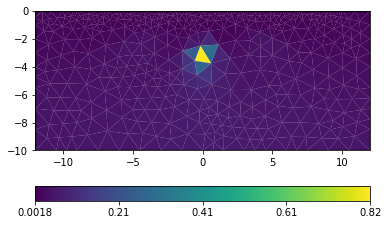

In [11]:
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mgr.paraDomain, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
errorIP = pg.Vector(data.size(), 0.03) + 0.001 / data["ma"]  # absolute ma error important
modelIP = invIP.run(data["ma"], errorIP, startModel=0.1, lam=10, verbose=True)
pg.show(mgr.paraDomain, modelIP, logScale=False);